In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
!pip install "numpy<2" "opencv-python==4.8.0.76" grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 57.8 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 MB 29.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 79.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 70.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.

In [2]:
# Basics
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from glob import glob  # <--- Added this to find your image files

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.cuda.amp import autocast, GradScaler

# Albumentations (for augmentations)
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Sklearn (for K-Fold and metrics)
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, cohen_kappa_score

# timm (for pretrained models)
import timm

# Grad-CAM (for "detection"/explainability)
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

import warnings
warnings.filterwarnings('ignore')

# Set random seed
import random
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

seed_everything(42)

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

In [3]:
class CFG:
    IMG_SIZE = 224
    BATCH_SIZE = 8 # You can lower this to 8 or 4 if you get memory errors
    LR = 1e-4
    EPOCHS = 30
    SEED = 42
    NUM_CLASSES = 5  # F0, F1, F2, F3, F4
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    EARLY_STOPPING_PATIENCE = 5
    N_SPLITS = 3 # Using 3-Fold Cross-Validation like in your notebook

# This line will run to show you the cell is complete
print(f"✅ Step 2: Configuration loaded. Device set to: {CFG.DEVICE}")

✅ Step 2: Configuration loaded. Device set to: cuda


Scanning directory: /kaggle/input/ultrasound-dataset/Dataset/
Class map defined: {'F0': 0, 'F1': 1, 'F2': 2, 'F3': 3, 'F4': 4}
Starting to load image paths...
   ...Found 2114 images in /kaggle/input/ultrasound-dataset/Dataset/F0
   ...Found 861 images in /kaggle/input/ultrasound-dataset/Dataset/F1
   ...Found 793 images in /kaggle/input/ultrasound-dataset/Dataset/F2
   ...Found 857 images in /kaggle/input/ultrasound-dataset/Dataset/F3
   ...Found 1698 images in /kaggle/input/ultrasound-dataset/Dataset/F4

✅ Step 3: Successfully loaded 6323 total images.
Generating class distribution plot...


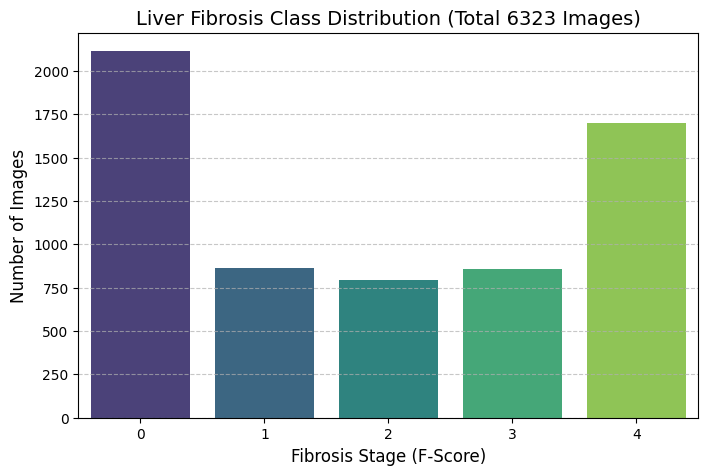

✅ Step 3: Plot generated successfully.


In [7]:
import pandas as pd
import os
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1. SET YOUR MAIN DATA DIRECTORY ---
# This path is based on your screenshot "ultrasound-dataset/Dataset/"
data_dir = "/kaggle/input/ultrasound-dataset/Dataset/" 
print(f"Scanning directory: {data_dir}")

# --- 2. DEFINE YOUR CLASSES ---
# This maps your folder names to the class labels (0, 1, 2, 3, 4)
class_map = {
    'F0': 0,
    'F1': 1,
    'F2': 2,
    'F3': 3,
    'F4': 4
}
print(f"Class map defined: {class_map}")

# --- 3. WALK THROUGH FOLDERS AND GET IMAGE PATHS ---
image_paths = []
labels = []

print("Starting to load image paths...")
for folder_name, class_label in class_map.items():
    folder_path = os.path.join(data_dir, folder_name)
    
    # Find all common image types
    images_in_folder = glob(os.path.join(folder_path, "*.png"))
    images_in_folder.extend(glob(os.path.join(folder_path, "*.jpg")))
    images_in_folder.extend(glob(os.path.join(folder_path, "*.jpeg")))
    
    for img_path in images_in_folder:
        image_paths.append(img_path)
        labels.append(class_label)
    # This line will print for each folder
    print(f"   ...Found {len(images_in_folder)} images in {folder_path}")

# --- 4. CREATE THE DATAFRAME ---
# This 'df' is the same as the one in the APTOS notebook
df = pd.DataFrame({
    'image_path': image_paths,
    'diagnosis': labels
})

# Shuffle the dataframe
df = df.sample(frac=1, random_state=CFG.SEED).reset_index(drop=True)

print(f"\n✅ Step 3: Successfully loaded {len(df)} total images.")

# --- 5. PLOT CLASS DISTRIBUTION ---
print("Generating class distribution plot...")
plt.figure(figsize=(8,5))
sns.barplot(
    x=df['diagnosis'].value_counts().sort_index().index,
    y=df['diagnosis'].value_counts().sort_index().values,
    palette='viridis'
)
plt.title(f"Liver Fibrosis Class Distribution (Total {len(df)} Images)", fontsize=14)
plt.xlabel("Fibrosis Stage (F-Score)", fontsize=12)
plt.ylabel("Number of Images", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
print("✅ Step 3: Plot generated successfully.")

Loading sample images for visualization...


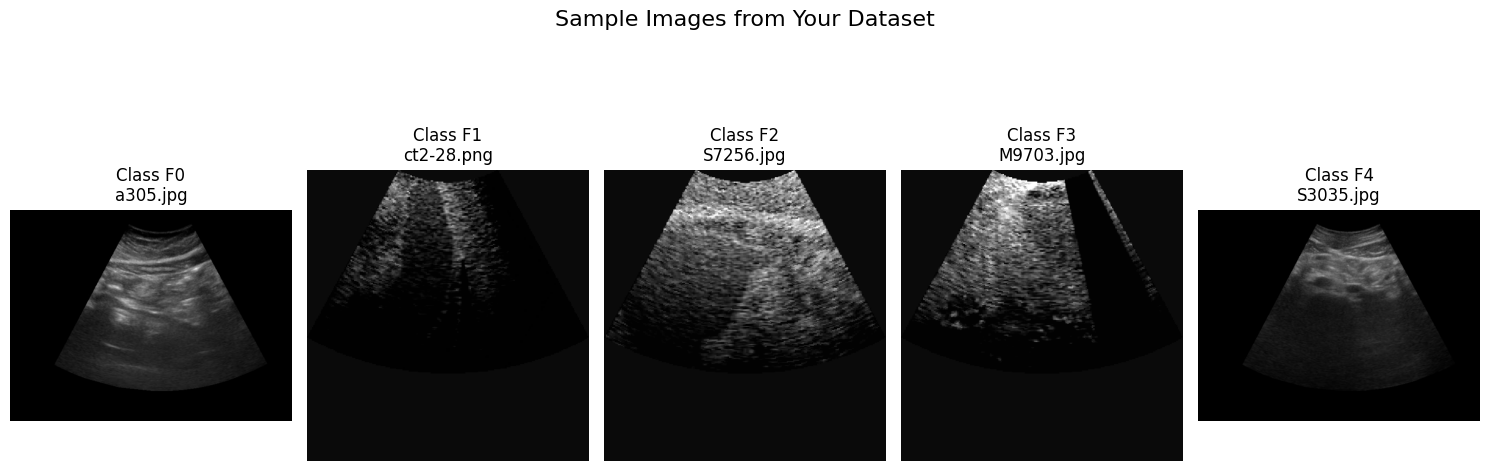

✅ Step 4: Sample images displayed.


In [8]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

print("Loading sample images for visualization...")

plt.figure(figsize=(15, 6))
for cls in range(CFG.NUM_CLASSES):
    # 1. Get one sample row from the dataframe for the current class
    sample_row = df[df['diagnosis'] == cls].sample(1).iloc[0]
    
    # 2. Load the image path
    image_path = sample_row.image_path
    
    # 3. Read the image using cv2
    img = cv2.imread(image_path)
    
    if img is None:
        print(f"Error: Could not load image {image_path}")
        continue
    
    # 4. Convert from BGR (cv2 default) to RGB (for plotting)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # 5. Plot the image
    plt.subplot(1, CFG.NUM_CLASSES, cls + 1)
    plt.imshow(img)
    plt.title(f"Class F{cls}\n{os.path.basename(image_path)}") # Show class and filename
    plt.axis("off")

plt.suptitle("Sample Images from Your Dataset", fontsize=16)
plt.tight_layout()
plt.show()

print("✅ Step 4: Sample images displayed.")

In [9]:
import cv2
import numpy as np

# --- Tool 1: CLAHE (from your notebook) ---
# This is great for enhancing low-contrast ultrasound images
def clahe_equalized(img_rgb):
    # Convert to LAB color space
    lab = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2LAB)
    
    # Split the LAB image
    l, a, b = cv2.split(lab)
    
    # Apply CLAHE to the L-channel
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    l_clahe = clahe.apply(l)
    
    # Merge the channels back
    lab_clahe = cv2.merge((l_clahe, a, b))
    
    # Convert back to RGB
    return cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2RGB)

# --- Tool 2: Sharpen (from your notebook) ---
# This helps define edges
def sharpen(img):
    # This is a standard sharpening kernel
    kernel = np.array([[-1,-1,-1], 
                       [-1, 9,-1], 
                       [-1,-1,-1]])
    return cv2.filter2D(img, -1, kernel)

# --- This is our NEW master function that the model will use ---
def preprocess_for_model(path):
    # 1. Read the image
    img = cv2.imread(path)
    if img is None:
        print(f"Warning: Could not read image {path}")
        return None
    
    # 2. Convert to 3-channel RGB (models need this)
    if len(img.shape) == 2 or img.shape[2] == 1:
        img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    else:
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
    # 3. *** NEW STEP: Reduce Speckle Noise ***
    # A Median Filter is very effective for ultrasound noise
    img_denoised = cv2.medianBlur(img_rgb, 3) # 3x3 kernel
    
    # 4. Enhance Contrast (from notebook)
    img_clahe = clahe_equalized(img_denoised)
    
    # 5. Sharpen Edges (from notebook)
    img_sharp = sharpen(img_clahe)
    
    return img_sharp

print("✅ Step 5: Advanced preprocessing functions defined.")
print("   (We REMOVED Log-Polar and ADDED Speckle Reduction)")

✅ Step 5: Advanced preprocessing functions defined.
   (We REMOVED Log-Polar and ADDED Speckle Reduction)


🚀 Starting Step 6.5: Visualizing Preprocessing Pipeline...
Loading sample image: a8178.jpg
Running preprocessing steps...


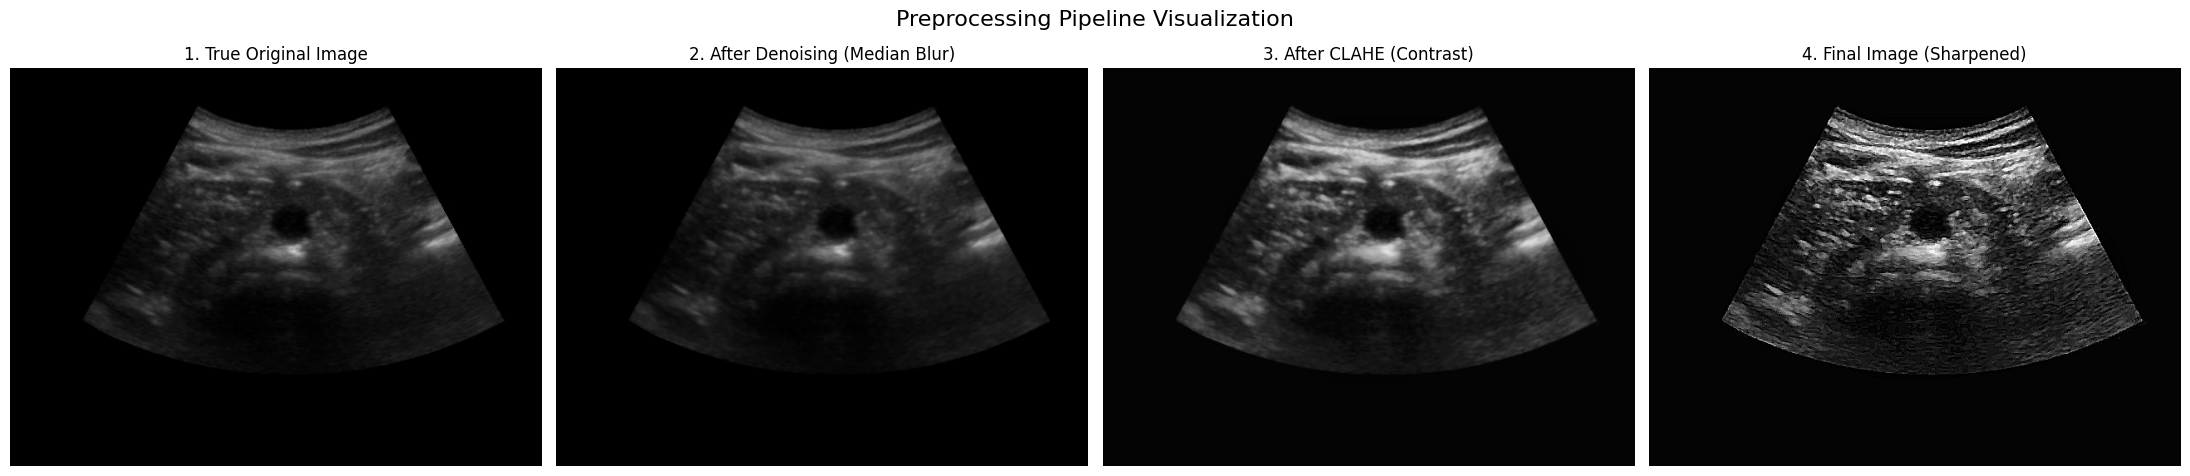


✅ Step 6.5: Visualization complete.


In [10]:
import matplotlib.pyplot as plt
import cv2

print("🚀 Starting Step 6.5: Visualizing Preprocessing Pipeline...")

# --- 1. Get one random sample image ---
# 'df' must exist from Step 4
try:
    sample_row = df.sample(1).iloc[0]
    img_path = sample_row.image_path
    print(f"Loading sample image: {os.path.basename(img_path)}")

    # --- 2. Load the True Original Image ---
    true_original = cv2.imread(img_path)
    if true_original is None:
        raise Exception("Could not read image")
    
    # Convert to RGB for plotting
    if len(true_original.shape) == 2 or true_original.shape[2] == 1:
        true_original_rgb = cv2.cvtColor(true_original, cv2.COLOR_GRAY2RGB)
    else:
        true_original_rgb = cv2.cvtColor(true_original, cv2.COLOR_BGR2RGB)

    # --- 3. Run each preprocessing step individually ---
    print("Running preprocessing steps...")
    
    # Step 3: Denoise
    img_denoised = cv2.medianBlur(true_original_rgb, 3)
    
    # Step 4: Enhance Contrast
    img_clahe = clahe_equalized(img_denoised)
    
    # Step 5: Sharpen Edges
    img_sharp = sharpen(img_clahe)
    
    # --- 4. Plot all 4 images side-by-side ---
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(22, 5))

    ax1.imshow(true_original_rgb)
    ax1.set_title("1. True Original Image")
    ax1.axis('off')

    ax2.imshow(img_denoised)
    ax2.set_title("2. After Denoising (Median Blur)")
    ax2.axis('off')

    ax3.imshow(img_clahe)
    ax3.set_title("3. After CLAHE (Contrast)")
    ax3.axis('off')
    
    ax4.imshow(img_sharp)
    ax4.set_title("4. Final Image (Sharpened)")
    ax4.axis('off')

    plt.suptitle("Preprocessing Pipeline Visualization", fontsize=16)
    plt.tight_layout()
    plt.show()

    print("\n✅ Step 6.5: Visualization complete.")

except NameError:
    print("❌ ERROR: 'df' is not defined. Please re-run Step 4 to load your data.")
except Exception as e:
    print(f"❌ ERROR: Could not load sample image. {e}")

In [11]:
# --- 1. Data Augmentations (from your notebook) ---
# These are applied *after* our preprocessing
train_tfms = A.Compose([
    A.Resize(height=CFG.IMG_SIZE, width=CFG.IMG_SIZE),
    A.OneOf([
        A.RandomRotate90(),
        A.Rotate(limit=30),
    ], p=0.7),
    # Removed RandomCrop as it might cut out key parts of ultrasound
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.2),
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=20, p=0.5),
    A.RandomBrightnessContrast(p=0.6),
    A.CoarseDropout(max_holes=8, max_height=CFG.IMG_SIZE//14, max_width=CFG.IMG_SIZE//14, p=0.4),
    A.Normalize(),
    ToTensorV2()
])

valid_tfms = A.Compose([
    A.Resize(height=CFG.IMG_SIZE, width=CFG.IMG_SIZE),
    A.Normalize(),
    ToTensorV2()
])


# --- 2. Custom PyTorch Dataset ---
# This class uses your new preprocessing function from Step 5
class LiverDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        print(f"Dataset created with {len(self.df)} images.") # Log message

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        # --- This is the key part ---
        # Use our new, advanced function from Step 5
        img = preprocess_for_model(row.image_path) 
        
        if img is None:
            # Handle a bad/missing image
            print(f"Error loading image {row.image_path}, returning dummy data for index {idx}")
            # Create a black image
            img = np.zeros((CFG.IMG_SIZE, CFG.IMG_SIZE, 3), dtype=np.uint8)
            label = torch.tensor(0, dtype=torch.long)
        else:
            # Get the real label
            label = torch.tensor(row.diagnosis, dtype=torch.long)

        # Apply augmentations (Resize, Rotate, Normalize, etc.)
        if self.transform:
            img = self.transform(image=img)["image"]
        
        return img, label

print("✅ Step 6: Augmentations and LiverDataset class defined.")

✅ Step 6: Augmentations and LiverDataset class defined.


In [12]:
import timm
import torch
import torch.nn as nn

# This is your new model class based on your supervisor's suggestions
class HybridDenseViT(nn.Module):
    def __init__(self, num_classes=CFG.NUM_CLASSES):
        super(HybridDenseViT, self).__init__()
        
        # --- 1. The CNN "Brain" (DenseNet-121) ---
        # This part is great at understanding local textures and patterns.
        self.cnn = timm.create_model(
            "densenet121",  # <-- Your Supervisor's Model
            pretrained=True, 
            num_classes=0, # We remove the original classifier head
            global_pool="avg" # This flattens the output to a 1D vector
        )
        # The feature vector from DenseNet-121 has 1024 features
        
        # --- 2. The Transformer "Brain" (ViT-Base) ---
        # This part is great at understanding the global context of the image.
        self.vit = timm.create_model(
            "vit_base_patch16_224", # <-- Your Supervisor's Model
            pretrained=True, 
            num_classes=0 # We remove the original classifier head
        )
        # The feature vector from ViT-Base has 768 features
        
        # --- 3. The "Boss" (Fully Connected Layer) ---
        # This layer combines the "notes" from both brains to make a final decision.
        self.fc = nn.Linear(
            self.cnn.num_features + self.vit.num_features, # (1024 + 768 = 1792 total features)
            num_classes
        )

    def forward(self, x):
        # 1. Get features from both models at the same time
        cnn_feat = self.cnn(x) 
        vit_feat = self.vit(x)
        
        # 2. Combine (fuse) the features into one "super-vector"
        out = torch.cat([cnn_feat, vit_feat], dim=1)
        
        # 3. Make the final classification (F0-F4)
        out = self.fc(out)
        return out

print("✅ Step 7: HybridDenseViT model class defined.")

✅ Step 7: HybridDenseViT model class defined.


In [13]:
import torch
import torch.nn as nn

class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.ce = nn.CrossEntropyLoss(reduction="none")
    
    def forward(self, inputs, targets):
        ce_loss = self.ce(inputs, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1-pt)**self.gamma * ce_loss
        return focal_loss.mean()

print("✅ Step 8: FocalLoss function defined. This will help with the imbalanced dataset.")

✅ Step 8: FocalLoss function defined. This will help with the imbalanced dataset.


In [ ]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import DataLoader, WeightedRandomSampler
from torch.cuda.amp import autocast, GradScaler
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import accuracy_score, cohen_kappa_score

# Keep track of scores
fold_metrics = []

# --- Start 3-Fold Cross-Validation ---
skf = StratifiedKFold(n_splits=CFG.N_SPLITS, shuffle=True, random_state=CFG.SEED)

print(f"🚀 Starting {CFG.N_SPLITS}-Fold Cross-Validation Training...")

for fold, (train_idx, valid_idx) in enumerate(skf.split(df, df['diagnosis'])):
    print(f"\n===================== FOLD {fold+1}/{CFG.N_SPLITS} =====================")
    
    train_df = df.iloc[train_idx]
    valid_df = df.iloc[valid_idx]
    
    # --- Tool #2 to Handle Imbalance (WeightedRandomSampler) ---
    print("Setting up WeightedRandomSampler for imbalanced data...")
    class_counts = train_df['diagnosis'].value_counts().to_dict()
    weights_per_class = {
        cls: 1.0 / count for cls, count in class_counts.items() if count > 0
    }
    weights = [
        weights_per_class.get(i, 0) for i in train_df['diagnosis']
    ]
    sampler = WeightedRandomSampler(
        weights, num_samples=len(weights), replacement=True
    )
    
    # --- Datasets ---
    print("Creating Datasets...")
    train_dataset = LiverDataset(train_df, transform=train_tfms)
    valid_dataset = LiverDataset(valid_df, transform=valid_tfms)
    
    # --- DataLoaders ---
    print("Creating DataLoaders...")
    train_loader = DataLoader(
        train_dataset, 
        batch_size=CFG.BATCH_SIZE, 
        sampler=sampler, # <-- Using the sampler here
        num_workers=2, 
        pin_memory=True
    )
    valid_loader = DataLoader(
        valid_dataset, 
        batch_size=CFG.BATCH_SIZE, 
        shuffle=False, 
        num_workers=2,
        pin_memory=True
    )
    
    # --- Model, Criterion, Optimizer, Scheduler ---
    print("Initializing Model, Loss, and Optimizer...")
    model = HybridDenseViT(num_classes=CFG.NUM_CLASSES).to(CFG.DEVICE) 
    criterion = FocalLoss() # <-- Using your special loss
    optimizer = optim.AdamW(model.parameters(), lr=CFG.LR, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="max", factor=0.5, patience=3, verbose=False # Set to True for more output
    )
    
    scaler = GradScaler() # for mixed precision
    
    best_qwk = -1
    no_improve = 0
    
    print(f"--- Starting Training for {CFG.EPOCHS} Epochs ---")
    for epoch in range(CFG.EPOCHS):
        
        # ------------------ TRAIN ------------------
        model.train()
        running_loss = 0.0
        running_corrects = 0
        total = 0
        
        # Use tqdm for a progress bar
        train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{CFG.EPOCHS} [Train]", leave=False)
        
        for images, labels in train_pbar:
            images = images.to(CFG.DEVICE)
            labels = labels.to(CFG.DEVICE)
            
            optimizer.zero_grad()
            
            with autocast(): # Mixed precision
                outputs = model(images)
                loss = criterion(outputs, labels)
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)
            total += labels.size(0)
            
            train_pbar.set_postfix(
                loss=running_loss/total, 
                acc=running_corrects.double().item()/total
            )
        
        train_loss = running_loss / total
        train_acc = running_corrects.double() / total
        
        # ------------------ VALIDATION ------------------
        model.eval()
        val_running_loss = 0.0
        val_total = 0
        all_preds = []
        all_labels = []
        
        # Use tqdm for a progress bar
        valid_pbar = tqdm(valid_loader, desc=f"Epoch {epoch+1}/{CFG.EPOCHS} [Valid]", leave=False)
        
        with torch.no_grad():
            for images, labels in valid_pbar:
                images = images.to(CFG.DEVICE)
                labels = labels.to(CFG.DEVICE)
                
                with autocast():
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                
                val_running_loss += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                val_total += labels.size(0)
                
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                
                valid_pbar.set_postfix(
                    loss=val_running_loss/val_total
                )
        
        val_loss = val_running_loss / val_total
        val_acc = accuracy_score(all_labels, all_preds)
        
        # --- This is the most important metric for you ---
        val_qwk = cohen_kappa_score(all_labels, all_preds, weights="quadratic")
        
        scheduler.step(val_qwk) # Step scheduler based on QWK
        
        # --- Print Epoch Summary ---
        print(f"Epoch {epoch+1}/{CFG.EPOCHS} Summary:")
        print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
        print(f"  Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f} | ⭐️ Val QWK: {val_qwk:.4f}")
        
        # --- Save best model ---
        if val_qwk > best_qwk:
            best_qwk = val_qwk
            no_improve = 0
            torch.save(model.state_dict(), f"fold{fold+1}_best_qwk.pth")
            print(f"  🎉 Model Saved! (Best QWK={best_qwk:.4f})")
        else:
            no_improve += 1
            print(f"  (No improvement for {no_improve} epoch(s).)")
        
        if no_improve >= CFG.EARLY_STOPPING_PATIENCE:
            print(f"--- ⚠️ Early stopping triggered after {epoch+1} epochs. ---")
            break
            
    # Store results for this fold
    fold_metrics.append({
        'fold': fold+1,
        'best_qwk': best_qwk
    })
    print(f"--- Finished Fold {fold+1}. Best QWK: {best_qwk:.4f} ---")

print("\n===================================================")
print("✅ Step 9: All training folds are complete.")
print("===================================================")
metrics_df = pd.DataFrame(fold_metrics)
print("\nFinal Model Performance (Best QWK per Fold):")
print(metrics_df)
print(f"\nAverage QWK across all {CFG.N_SPLITS} folds: {metrics_df['best_qwk'].mean():.4f}")

🚀 Starting Step 10: Evaluation (now saving probabilities)...

===== Evaluating Fold 1/3 =====
Dataset created with 2108 images.
Running predictions for Fold 1...


Predicting Fold 1: 100%|██████████| 264/264 [00:34<00:00,  7.62it/s]


Plotting Confusion Matrix for Fold 1...


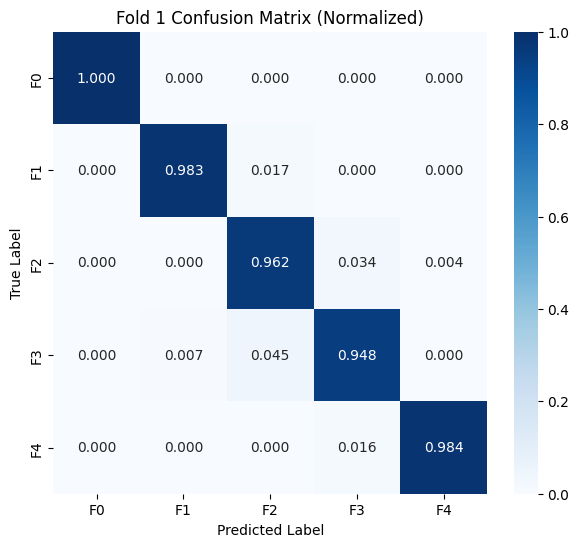


===== Evaluating Fold 2/3 =====
Dataset created with 2108 images.
Running predictions for Fold 2...


Predicting Fold 2: 100%|██████████| 264/264 [00:36<00:00,  7.24it/s]


Plotting Confusion Matrix for Fold 2...


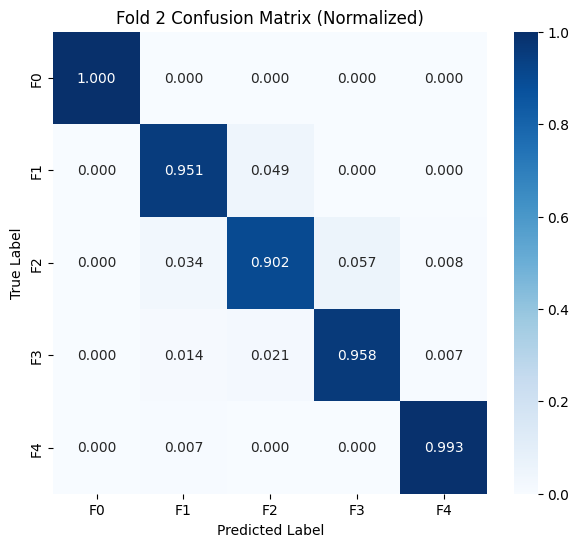


===== Evaluating Fold 3/3 =====
Dataset created with 2107 images.
Running predictions for Fold 3...


Predicting Fold 3: 100%|██████████| 264/264 [00:34<00:00,  7.61it/s]


Plotting Confusion Matrix for Fold 3...


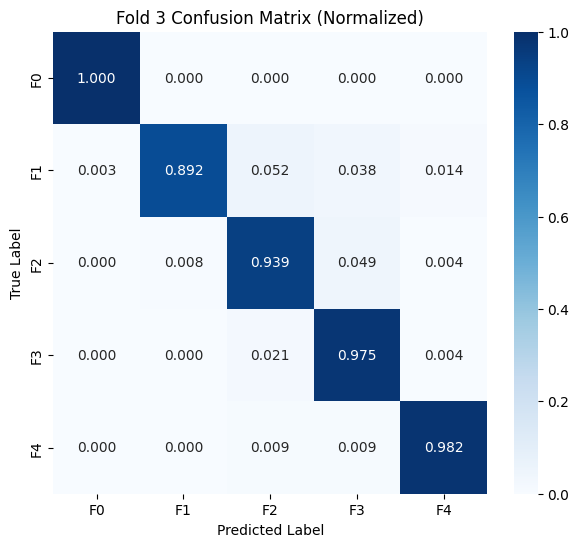


📊 Overall OOF (Out-of-Fold) Metrics
Overall Accuracy (all folds combined): 0.9749
Overall QWK (all folds combined): 0.9911

=== Overall Classification Report ===
(Sensitivity = recall)
              precision    recall  f1-score   support

          F0     0.9995    1.0000    0.9998      2114
          F1     0.9748    0.9419    0.9581       861
          F2     0.9205    0.9344    0.9274       793
          F3     0.9299    0.9603    0.9449       857
          F4     0.9935    0.9865    0.9900      1698

    accuracy                         0.9749      6323
   macro avg     0.9636    0.9646    0.9640      6323
weighted avg     0.9752    0.9749    0.9749      6323


✅ Step 10: Evaluation complete. Probabilities are now saved.


In [18]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, cohen_kappa_score
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F # <-- Import softmax
from tqdm import tqdm

print("🚀 Starting Step 10: Evaluation (now saving probabilities)...")

# --- THIS IS THE FIX ---
# We are now pointing to your 'saved_model' input folder
model_paths = [f"/kaggle/input/saved-model/fold{i+1}_best_qwk.pth" for i in range(CFG.N_SPLITS)]
# ---------------------

# These lists will store the results from all folds
all_fold_preds = []
all_fold_labels = []
all_fold_probs = [] # <--- NEW: We will store probabilities here

# Redo the KFold split just to get the validation indexes
skf = StratifiedKFold(n_splits=CFG.N_SPLITS, shuffle=True, random_state=CFG.SEED)

for fold, (train_idx, valid_idx) in enumerate(skf.split(df, df["diagnosis"])):
    print(f"\n===== Evaluating Fold {fold+1}/{CFG.N_SPLITS} =====")
    
    valid_df = df.iloc[valid_idx]
    
    # Create dataset and loader for this fold's validation data
    valid_dataset = LiverDataset(valid_df, transform=valid_tfms)
    valid_loader = DataLoader(
        valid_dataset, batch_size=CFG.BATCH_SIZE, shuffle=False, num_workers=2
    )
    
    # Load the trained model for this fold
    model = HybridDenseViT(num_classes=CFG.NUM_CLASSES).to(CFG.DEVICE)
    
    # Check if model file exists before loading
    if not os.path.exists(model_paths[fold]):
        print(f"❌ ERROR: Model file not found at {model_paths[fold]}")
        print("Please check the 'saved_model' folder name in your 'Input' panel.")
        break
        
    model.load_state_dict(torch.load(model_paths[fold], map_location=CFG.DEVICE))
    model.eval()
    
    fold_preds = []
    fold_labels = []
    
    print(f"Running predictions for Fold {fold+1}...")
    with torch.no_grad():
        for images, labels in tqdm(valid_loader, desc=f"Predicting Fold {fold+1}"):
            images = images.to(CFG.DEVICE)
            
            outputs = model(images)
            probs = F.softmax(outputs, dim=1) # <--- NEW: Get probabilities
            _, preds = torch.max(outputs, 1)
            
            fold_preds.extend(preds.cpu().numpy())
            fold_labels.extend(labels.cpu().numpy())
            all_fold_probs.extend(probs.cpu().numpy()) # <--- NEW: Save probabilities
            
    # Add this fold's results to the master lists
    all_fold_preds.extend(fold_preds)
    all_fold_labels.extend(fold_labels)
            
    # --- Plot Confusion Matrix for THIS FOLD ---
    print(f"Plotting Confusion Matrix for Fold {fold+1}...")
    cm_fold = confusion_matrix(fold_labels, fold_preds)
    # Handle potential division by zero if a class has 0 samples in this fold
    cm_norm_fold = cm_fold.astype('float') / cm_fold.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(7, 6))
    sns.heatmap(cm_norm_fold, annot=True, cmap="Blues", fmt=".3f",
                xticklabels=class_map.keys(),
                yticklabels=class_map.keys())
    plt.title(f"Fold {fold+1} Confusion Matrix (Normalized)")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

# --- Convert lists to numpy arrays for overall metrics ---
all_fold_labels = np.array(all_fold_labels)
all_fold_preds = np.array(all_fold_preds)
all_fold_probs_np = np.array(all_fold_probs) # <--- NEW: Our final probabilities array

print("\n===================================================")
print("📊 Overall OOF (Out-of-Fold) Metrics")
print("===================================================")
overall_acc = accuracy_score(all_fold_labels, all_fold_preds)
overall_qwk = cohen_kappa_score(all_fold_labels, all_fold_preds, weights="quadratic")

print(f"Overall Accuracy (all folds combined): {overall_acc:.4f}")
print(f"Overall QWK (all folds combined): {overall_qwk:.4f}")

print("\n=== Overall Classification Report ===")
print("(Sensitivity = recall)")
print(classification_report(
    all_fold_labels, 
    all_fold_preds, 
    target_names=class_map.keys(), 
    digits=4
))

print("\n✅ Step 10: Evaluation complete. Probabilities are now saved.")


🚀 Starting Step 10.5: Plotting Overall Confusion Matrix & Calculating Specificity...
Overall Confusion Matrix (Raw Counts):
[[2114    0    0    0    0]
 [   1  811   34   11    4]
 [   0   11  741   37    4]
 [   0    6   25  823    3]
 [   0    4    5   14 1675]]

Plotting Overall Raw Count Confusion Matrix...


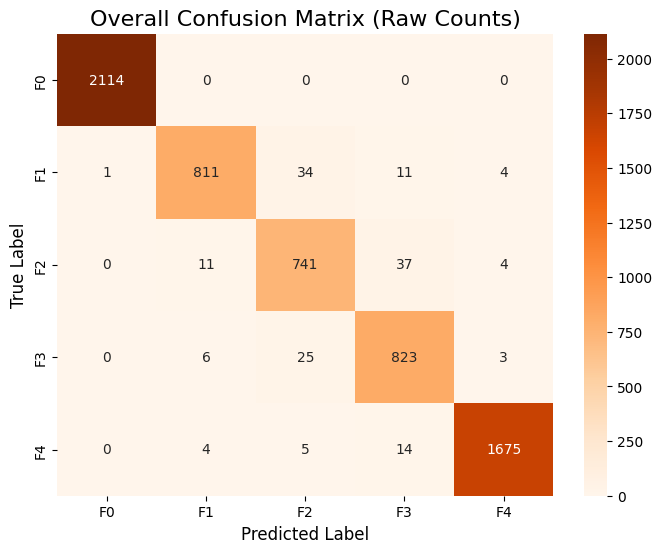


--- Specificity per Class ---
F0 (Class 0) Specificity: 0.9998
F1 (Class 1) Specificity: 0.9962
F2 (Class 2) Specificity: 0.9884
F3 (Class 3) Specificity: 0.9887
F4 (Class 4) Specificity: 0.9976

✅ Step 10.5: Specificity and plot complete.


In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

print("🚀 Starting Step 10.5: Plotting Overall Confusion Matrix & Calculating Specificity...")

# --- 1. Generate the Overall Confusion Matrix ---
# This 'cm' variable will be used for both the plot and the calculations.
# 'all_fold_labels' and 'all_fold_preds' were created in Step 10.
cm = confusion_matrix(all_fold_labels, all_fold_preds)

print("Overall Confusion Matrix (Raw Counts):")
print(cm) # Print the text version first

# --- 2. Plot the Overall Confusion Matrix (Raw Counts) ---
print("\nPlotting Overall Raw Count Confusion Matrix...")
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm, 
    annot=True,     # Show the numbers in each cell
    fmt="d",        # Format the numbers as integers (e.g., "2114")
    cmap="Oranges", # Use an orange color map, like your example
    xticklabels=class_map.keys(),
    yticklabels=class_map.keys()
)
plt.title("Overall Confusion Matrix (Raw Counts)", fontsize=16)
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.show() # This will display the heatmap plot

# --- 3. Calculate Specificity (using the same 'cm') ---
print("\n--- Specificity per Class ---")

for i, class_name in enumerate(class_map.keys()):
    # Specificity = True Negatives / (True Negatives + False Positives)
    
    # True Negatives (TN) = Sum of all cells NOT in the current class's row or column
    tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
    
    # False Positives (FP) = Sum of the column for this class, minus the true positive
    fp = cm[:, i].sum() - cm[i, i]
    
    # Calculate specificity and handle division by zero
    if (tn + fp) == 0:
        specificity = 1.0  # Or 0.0, depending on definition. 1.0 means no false positives.
    else:
        specificity = tn / (tn + fp)
    
    print(f"{class_name} (Class {i}) Specificity: {specificity:.4f}")

print("\n✅ Step 10.5: Specificity and plot complete.")

🚀 Starting Step 10.5.2: Plotting Overall Normalized Confusion Matrix...


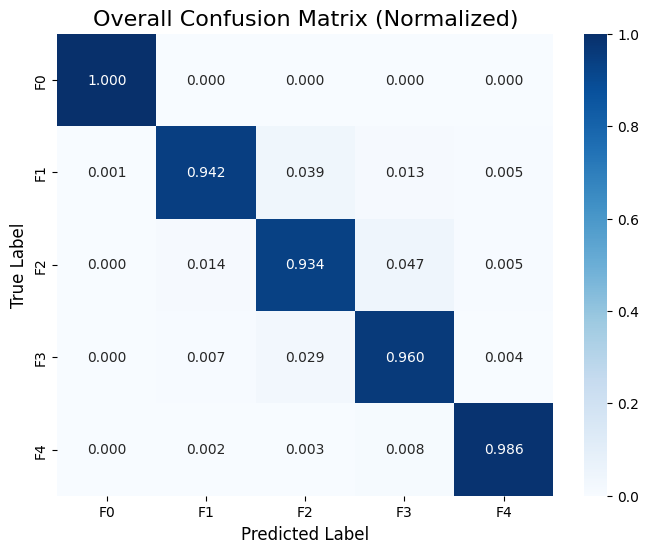


✅ Step 10.5.2: Overall normalized plot complete.


In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

print("🚀 Starting Step 10.5.2: Plotting Overall Normalized Confusion Matrix...")

# 'cm' variable still exists in memory from the previous cell.
# 1. Normalize the confusion matrix
# We divide each row by its sum to get percentages
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# 2. Plot the normalized heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_norm, 
    annot=True,     # Show the numbers in each cell
    fmt=".3f",      # Format the numbers as decimals (e.g., "0.998")
    cmap="Blues",   # Use a blue color map for this one
    xticklabels=class_map.keys(),
    yticklabels=class_map.keys()
)
plt.title("Overall Confusion Matrix (Normalized)", fontsize=16)
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.show()

print("\n✅ Step 10.5.2: Overall normalized plot complete.")

🚀 Starting Step 10.6: Plotting ROC/AUC Curves...


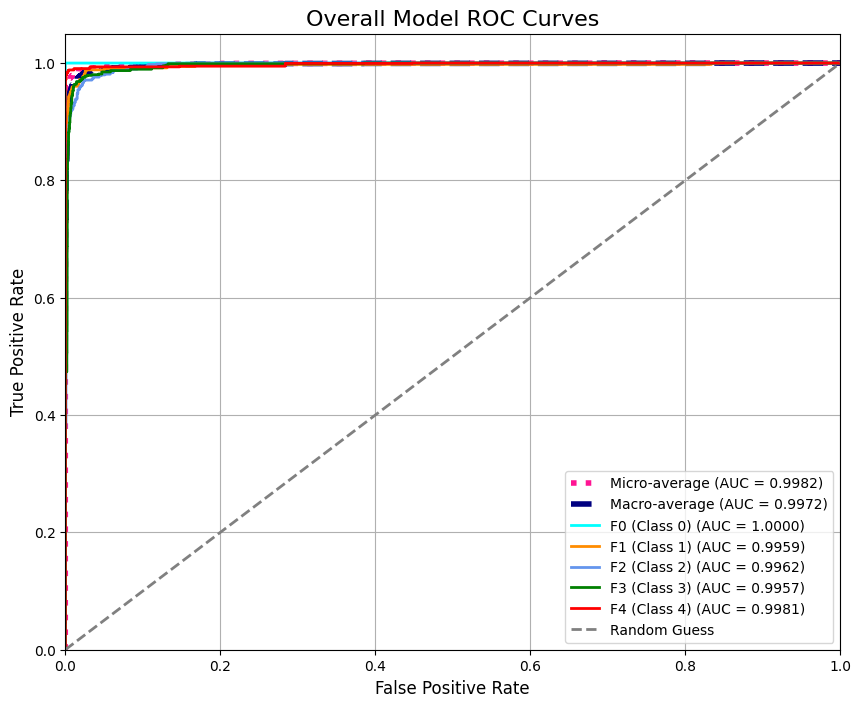


✅ Step 10.6: ROC/AUC plot complete.


In [21]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle

print("🚀 Starting Step 10.6: Plotting ROC/AUC Curves...")

# Binarize the true labels (OVR - One-vs-Rest)
# 'all_fold_labels' and 'all_fold_probs_np' were created in Step 10
y_true_bin = label_binarize(all_fold_labels, classes=[0, 1, 2, 3, 4])
n_classes = CFG.NUM_CLASSES

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], all_fold_probs_np[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# --- Compute Micro-average ROC ---
# (Calculates metrics globally by counting total TPs, FPs, etc.)
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), all_fold_probs_np.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# --- Compute Macro-average ROC ---
# (Calculates metrics for each label, and finds their unweighted mean)
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# --- Plot all ROC curves ---
plt.figure(figsize=(10, 8)) # Make the plot a bit bigger

# Plot Micro-average
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average (AUC = {roc_auc["micro"]:0.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot Macro-average
plt.plot(fpr["macro"], tpr["macro"],
         label=f'Macro-average (AUC = {roc_auc["macro"]:0.4f})',
         color='navy', linestyle='--', linewidth=4)

# Plot per-class ROC
# Get class names from your class_map
class_names = list(class_map.keys()) 
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'{class_names[i]} (Class {i}) (AUC = {roc_auc[i]:0.4f})')

# Plot the "random guess" line
plt.plot([0, 1], [0, 1], 'k--', lw=2, color='gray', label='Random Guess')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Overall Model ROC Curves', fontsize=16)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True)
plt.show()

print("\n✅ Step 10.6: ROC/AUC plot complete.")

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F

print("🚀 Starting Step 11: Creating the final Ensemble Model...")

# 1. Define the Ensemble Wrapper Class
# This class just holds your 3 trained models
class EnsembleHybridModel(nn.Module):
    def __init__(self, model_paths, num_classes):
        super().__init__()
        self.num_classes = num_classes
        
        # Create a list to hold the 3 models
        self.models = nn.ModuleList()
        
        # Load each of the 3 models into the list
        for path in model_paths:
            # Create a new, untrained model
            model_instance = HybridDenseViT(num_classes=self.num_classes)
            # Load the saved weights from training
            model_instance.load_state_dict(torch.load(path, map_location=CFG.DEVICE))
            model_instance.eval() # Set to evaluation mode
            self.models.append(model_instance)
        
        print(f"Ensemble loaded with {len(self.models)} models.")

    def forward(self, x):
        # It gets the output (probabilities) from each model
        probs_list = []
        with torch.no_grad():
            for model in self.models:
                outputs = model(x)
                probs = F.softmax(outputs, dim=1)
                probs_list.append(probs)
        
        # Average the probabilities from all 3 models
        avg_probs = torch.mean(torch.stack(probs_list), dim=0)
        return avg_probs

# --- THIS IS THE FIX ---
# We are now pointing to your 'saved_model' input folder
model_paths = [f"/kaggle/input/saved-model/fold{i+1}_best_qwk.pth" for i in range(CFG.N_SPLITS)]
# ---------------------
print(f"Found models: {model_paths}")

# 3. Create an instance of the Ensemble Model
ensemble_model = EnsembleHybridModel(model_paths, num_classes=CFG.NUM_CLASSES).to(CFG.DEVICE)

# 4. Save the ENTIRE ensemble to a single file in the /kaggle/working/ folder
save_path = "ensemble_model_us.pth"
torch.save(ensemble_model.state_dict(), save_path)

print(f"\n✅ Step 11: Final ensemble model saved successfully to: {save_path}")

🚀 Starting Step 11: Creating the final Ensemble Model...
Found models: ['/kaggle/input/saved-model/fold1_best_qwk.pth', '/kaggle/input/saved-model/fold2_best_qwk.pth', '/kaggle/input/saved-model/fold3_best_qwk.pth']
Ensemble loaded with 3 models.

✅ Step 11: Final ensemble model saved successfully to: ensemble_model_us.pth


In [26]:
import torch
import cv2
import numpy as np

print("🚀 Starting Step 12: Inference test with the final ensemble model...")

# --- 1. Get a random sample image to test ---
sample_row = df.sample(1).iloc[0]
true_label = sample_row.diagnosis
img_path = sample_row.image_path

print(f"Loading random sample image: {os.path.basename(img_path)}")
print(f"True Label: F{true_label}")

# --- 2. Load the image and preprocess it ---
# We use the same pipeline as training
img = preprocess_for_model(img_path)
img_resized = cv2.resize(img, (CFG.IMG_SIZE, CFG.IMG_SIZE))

# Apply validation transforms (Resize, Normalize, ToTensor)
input_tensor = valid_tfms(image=img_resized)["image"].unsqueeze(0).to(CFG.DEVICE)

# --- 3. Load your new ensemble model ---
print("Loading ensemble_model_us.pth...")

# --- THIS IS THE FIX ---
# We point to your 'saved_model' folder to load the folds
model_paths = [f"/kaggle/input/saved-model/fold{i+1}_best_qwk.pth" for i in range(CFG.N_SPLITS)]
# ---------------------

# We re-define the class (this is necessary)
ensemble_model = EnsembleHybridModel(model_paths, num_classes=CFG.NUM_CLASSES).to(CFG.DEVICE)

# We load the ensemble model from /kaggle/working/ (where Step 11 saved it)
ensemble_model.load_state_dict(torch.load("ensemble_model_us.pth", map_location=CFG.DEVICE))
ensemble_model.eval() # Set to evaluation mode

# --- 4. Make a prediction ---
with torch.no_grad():
    # The model outputs probabilities (e.g., [0.1, 0.2, 0.6, 0.1, 0.0])
    probs = ensemble_model(input_tensor)
    
    # Get the highest probability class
    pred_class = torch.argmax(probs, dim=1).item()
    pred_prob = probs.max().item() * 100 # Get the confidence score

print("\n--- Inference Result ---")
print(f"Predicted Label: F{pred_class}")
print(f"Confidence: {pred_prob:.2f}%")

if pred_class == true_label:
    print("✅ Result: Correct!")
else:
    print("❌ Result: Incorrect.")

print("\n✅ Step 12: Inference test complete.")

🚀 Starting Step 12: Inference test with the final ensemble model...
Loading random sample image: I8920.jpg
True Label: F1
Loading ensemble_model_us.pth...
Ensemble loaded with 3 models.

--- Inference Result ---
Predicted Label: F1
Confidence: 91.72%
✅ Result: Correct!

✅ Step 12: Inference test complete.


🚀 Starting Step 13 (Corrected Fix): Explainability...
Loading ensemble_model_us.pth to access the sub-models...
Ensemble re-loaded with 3 models.
Grad-CAM objects created.

--- Running on Sample Image ---
Image Path: I8920.jpg
True Label: F1 | Predicted Label: F1


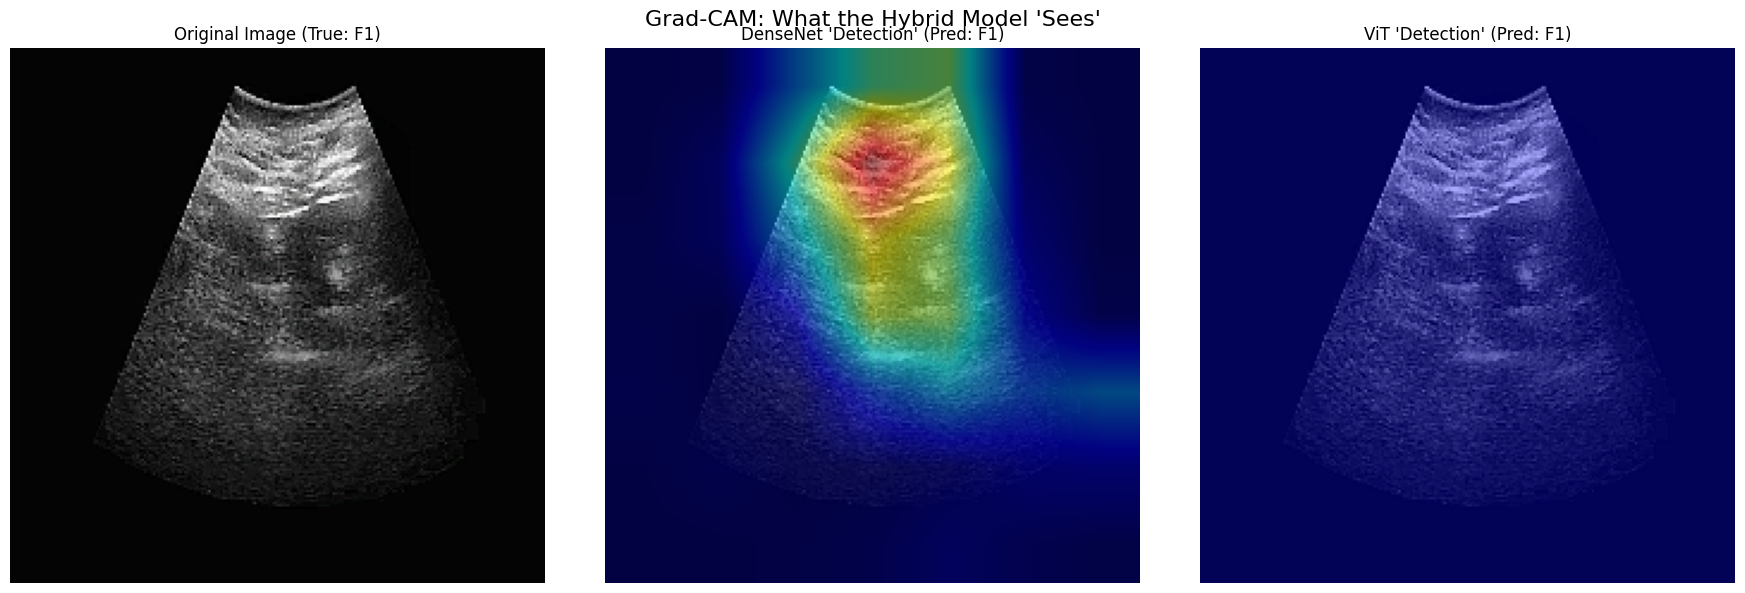


✅ Step 13: Grad-CAM detection complete.


In [28]:
import torch
from pytorch_grad_cam import GradCAM # or LayerCAM, whichever you prefer
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random

print("🚀 Starting Step 13 (Corrected Fix): Explainability...")

# --- 1. This function helps resize ViT's heatmap ---
def reshape_transform_vit(tensor, height=14, width=14):
    result = tensor[:, 1:, :].reshape(tensor.size(0), height, width, tensor.size(2))
    result = result.permute(0, 3, 1, 2)
    return result

# --- 2. Load your ENSEMBLE model (which contains the sub-models) ---
print("Loading ensemble_model_us.pth to access the sub-models...")

# We must re-define the EnsembleHybridModel class so torch can load it
class EnsembleHybridModel(nn.Module):
    def __init__(self, model_paths, num_classes):
        super().__init__()
        self.num_classes = num_classes
        self.models = nn.ModuleList()
        for path in model_paths:
            model_instance = HybridDenseViT(num_classes=self.num_classes)
            model_instance.load_state_dict(torch.load(path, map_location=CFG.DEVICE))
            model_instance.eval() # Set to evaluation mode
            self.models.append(model_instance)
        print(f"Ensemble re-loaded with {len(self.models)} models.")
        
    def forward(self, x):
        probs_list = []
        with torch.no_grad():
            for model in self.models:
                outputs = model(x); probs = F.softmax(outputs, dim=1)
                probs_list.append(probs)
        avg_probs = torch.mean(torch.stack(probs_list), dim=0)
        return avg_probs
        
# --- THIS IS THE FIX ---
# We point to your 'saved_model' folder to load the folds
model_paths = [f"/kaggle/input/saved-model/fold{i+1}_best_qwk.pth" for i in range(CFG.N_SPLITS)]
# ---------------------

ensemble_model = EnsembleHybridModel(model_paths, num_classes=CFG.NUM_CLASSES).to(CFG.DEVICE)
# We load the ensemble wrapper from /kaggle/working/ (where Step 11 saved it)
ensemble_model.load_state_dict(torch.load("ensemble_model_us.pth", map_location=CFG.DEVICE))
ensemble_model.eval()

model_to_explain = ensemble_model.models[0] # Explain using the Fold 1 model

# --- 3. Define the target layers from that sub-model ---
target_layers_cnn = [model_to_explain.cnn.features.norm5]
target_layers_vit = [model_to_explain.vit.blocks[-1].norm1] # Last block of ViT

# --- 4. Create the CAM objects ---
# You can change GradCAM to LayerCAM if you prefer
cam_cnn = GradCAM(model=model_to_explain, 
                  target_layers=target_layers_cnn)

cam_vit = GradCAM(model=model_to_explain, 
                  target_layers=target_layers_vit,
                  reshape_transform=reshape_transform_vit) 
                  
print("Grad-CAM objects created.")

# --- 5. Get the sample image from Step 12 ---
# 'sample_row', 'true_label', 'img_path', 'pred_class'
# all still exist in memory from the previous cell
print(f"\n--- Running on Sample Image ---")
print(f"Image Path: {os.path.basename(img_path)}")
print(f"True Label: F{true_label} | Predicted Label: F{pred_class}")

# --- 6. Preprocess the image ---
orig_img = preprocess_for_model(img_path)
orig_img_resized = cv2.resize(orig_img, (CFG.IMG_SIZE, CFG.IMG_SIZE))
# 'input_tensor' also still exists from Step 12

# --- 7. Generate the heatmaps ---
targets = [ClassifierOutputTarget(pred_class)]
grayscale_cam_cnn = cam_cnn(input_tensor=input_tensor, targets=targets)[0, :]
grayscale_cam_vit = cam_vit(input_tensor=input_tensor, targets=targets)[0, :]

# --- 8. Plot the results ---
plot_img = orig_img_resized.astype(np.float32) / 255.0
heatmap_cnn = show_cam_on_image(plot_img, grayscale_cam_cnn, use_rgb=True)
heatmap_vit = show_cam_on_image(plot_img, grayscale_cam_vit, use_rgb=True) 

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
ax1.imshow(plot_img)
ax1.set_title(f"Original Image (True: F{true_label})")
ax1.axis('off')

ax2.imshow(heatmap_cnn)
ax2.set_title(f"DenseNet 'Detection' (Pred: F{pred_class})")
ax2.axis('off')

ax3.imshow(heatmap_vit)
ax3.set_title(f"ViT 'Detection' (Pred: F{pred_class})")
ax3.axis('off')

plt.suptitle("Grad-CAM: What the Hybrid Model 'Sees'", fontsize=16)
plt.tight_layout()
plt.show()

print("\n✅ Step 13: Grad-CAM detection complete.")

🚀 Starting Step 13 (Corrected Fix): Explainability with LayerCAM...
Loading ensemble_model_us.pth to access the sub-models...
Ensemble re-loaded with 3 models.
LayerCAM objects created.

--- Running on Sample Image ---
Image Path: I8920.jpg
True Label: F1 | Predicted Label: F1


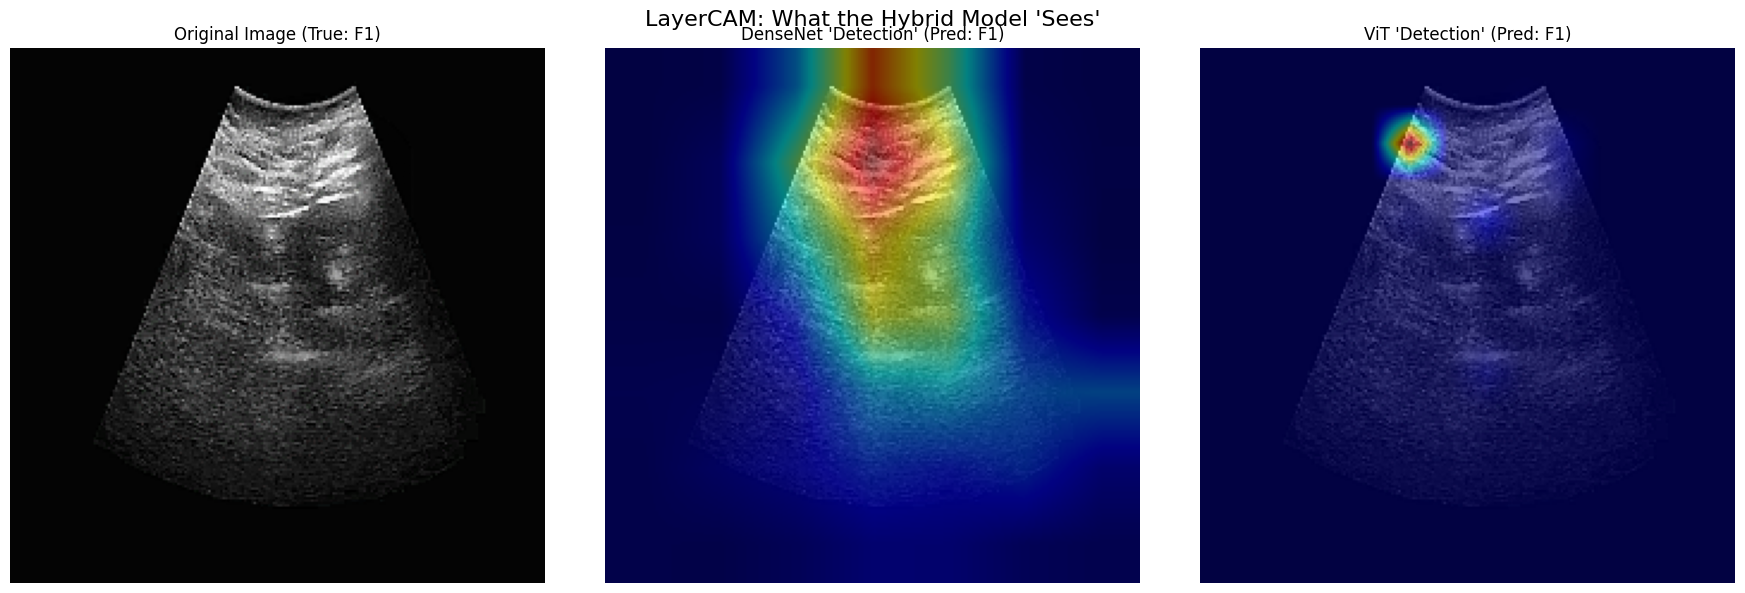


✅ Step 13: LayerCAM detection complete.


In [29]:
import torch
from pytorch_grad_cam import LayerCAM  # <--- Using LayerCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random

print("🚀 Starting Step 13 (Corrected Fix): Explainability with LayerCAM...")

# --- 1. ViT reshape function (still needed) ---
def reshape_transform_vit(tensor, height=14, width=14):
    result = tensor[:, 1:, :].reshape(tensor.size(0), height, width, tensor.size(2))
    result = result.permute(0, 3, 1, 2)
    return result

# --- 2. Load your ENSEMBLE model (which contains the sub-models) ---
print("Loading ensemble_model_us.pth to access the sub-models...")
# We must re-define the EnsembleHybridModel class so torch can load it
class EnsembleHybridModel(nn.Module):
    def __init__(self, model_paths, num_classes):
        super().__init__()
        self.num_classes = num_classes
        self.models = nn.ModuleList()
        for path in model_paths:
            model_instance = HybridDenseViT(num_classes=self.num_classes)
            model_instance.load_state_dict(torch.load(path, map_location=CFG.DEVICE))
            model_instance.eval() # Set to evaluation mode
            self.models.append(model_instance)
        print(f"Ensemble re-loaded with {len(self.models)} models.")
        
    def forward(self, x):
        probs_list = []
        with torch.no_grad():
            for model in self.models:
                outputs = model(x); probs = F.softmax(outputs, dim=1)
                probs_list.append(probs)
        avg_probs = torch.mean(torch.stack(probs_list), dim=0)
        return avg_probs
        
# --- THIS IS THE FIX ---
# We point to your 'saved_model' folder to load the folds
model_paths = [f"/kaggle/input/saved-model/fold{i+1}_best_qwk.pth" for i in range(CFG.N_SPLITS)]
# ---------------------

ensemble_model = EnsembleHybridModel(model_paths, num_classes=CFG.NUM_CLASSES).to(CFG.DEVICE)
# We load the ensemble wrapper from /kaggle/working/ (where Step 11 saved it)
ensemble_model.load_state_dict(torch.load("ensemble_model_us.pth", map_location=CFG.DEVICE))
ensemble_model.eval()

model_to_explain = ensemble_model.models[0] # Explain using the Fold 1 model

# --- 3. Define the target layers from that sub-model ---
target_layers_cnn = [model_to_explain.cnn.features.norm5]
target_layers_vit = [model_to_explain.vit.blocks[-1].norm1] # Last block of ViT

# --- 4. Create the CAM objects ---
cam_cnn = LayerCAM(model=model_to_explain, 
                  target_layers=target_layers_cnn)

cam_vit = LayerCAM(model=model_to_explain, 
                  target_layers=target_layers_vit,
                  reshape_transform=reshape_transform_vit) 
                  
print("LayerCAM objects created.")

# --- 5. Get the sample image from Step 12 ---
# 'sample_row', 'true_label', 'img_path', 'pred_class'
# all still exist in memory from the previous cell
print(f"\n--- Running on Sample Image ---")
print(f"Image Path: {os.path.basename(img_path)}")
print(f"True Label: F{true_label} | Predicted Label: F{pred_class}")

# --- 6. Preprocess the image ---
orig_img = preprocess_for_model(img_path)
orig_img_resized = cv2.resize(orig_img, (CFG.IMG_SIZE, CFG.IMG_SIZE))
# 'input_tensor' also still exists from Step 12

# --- 7. Generate the heatmaps ---
targets = [ClassifierOutputTarget(pred_class)]
grayscale_cam_cnn = cam_cnn(input_tensor=input_tensor, targets=targets)[0, :]
grayscale_cam_vit = cam_vit(input_tensor=input_tensor, targets=targets)[0, :]

# --- 8. Plot the results ---
plot_img = orig_img_resized.astype(np.float32) / 255.0
heatmap_cnn = show_cam_on_image(plot_img, grayscale_cam_cnn, use_rgb=True)
heatmap_vit = show_cam_on_image(plot_img, grayscale_cam_vit, use_rgb=True) 

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
ax1.imshow(plot_img)
ax1.set_title(f"Original Image (True: F{true_label})")
ax1.axis('off')

ax2.imshow(heatmap_cnn)
ax2.set_title(f"DenseNet 'Detection' (Pred: F{pred_class})")
ax2.axis('off')

ax3.imshow(heatmap_vit)
ax3.set_title(f"ViT 'Detection' (Pred: F{pred_class})")
ax3.axis('off')

plt.suptitle("LayerCAM: What the Hybrid Model 'Sees'", fontsize=16)
plt.tight_layout()
plt.show()

print("\n✅ Step 13: LayerCAM detection complete.")

🚀 Starting Inference and Visualization for New Image...
Found image: /kaggle/input/test-image/t4740.jpg
Loading ensemble_model_us.pth...
Ensemble re-loaded with 3 models.
LayerCAM objects created.
Processing new image...

--- Model Prediction ---
Predicted Label: F2 (Class 2)
Confidence: 95.78%


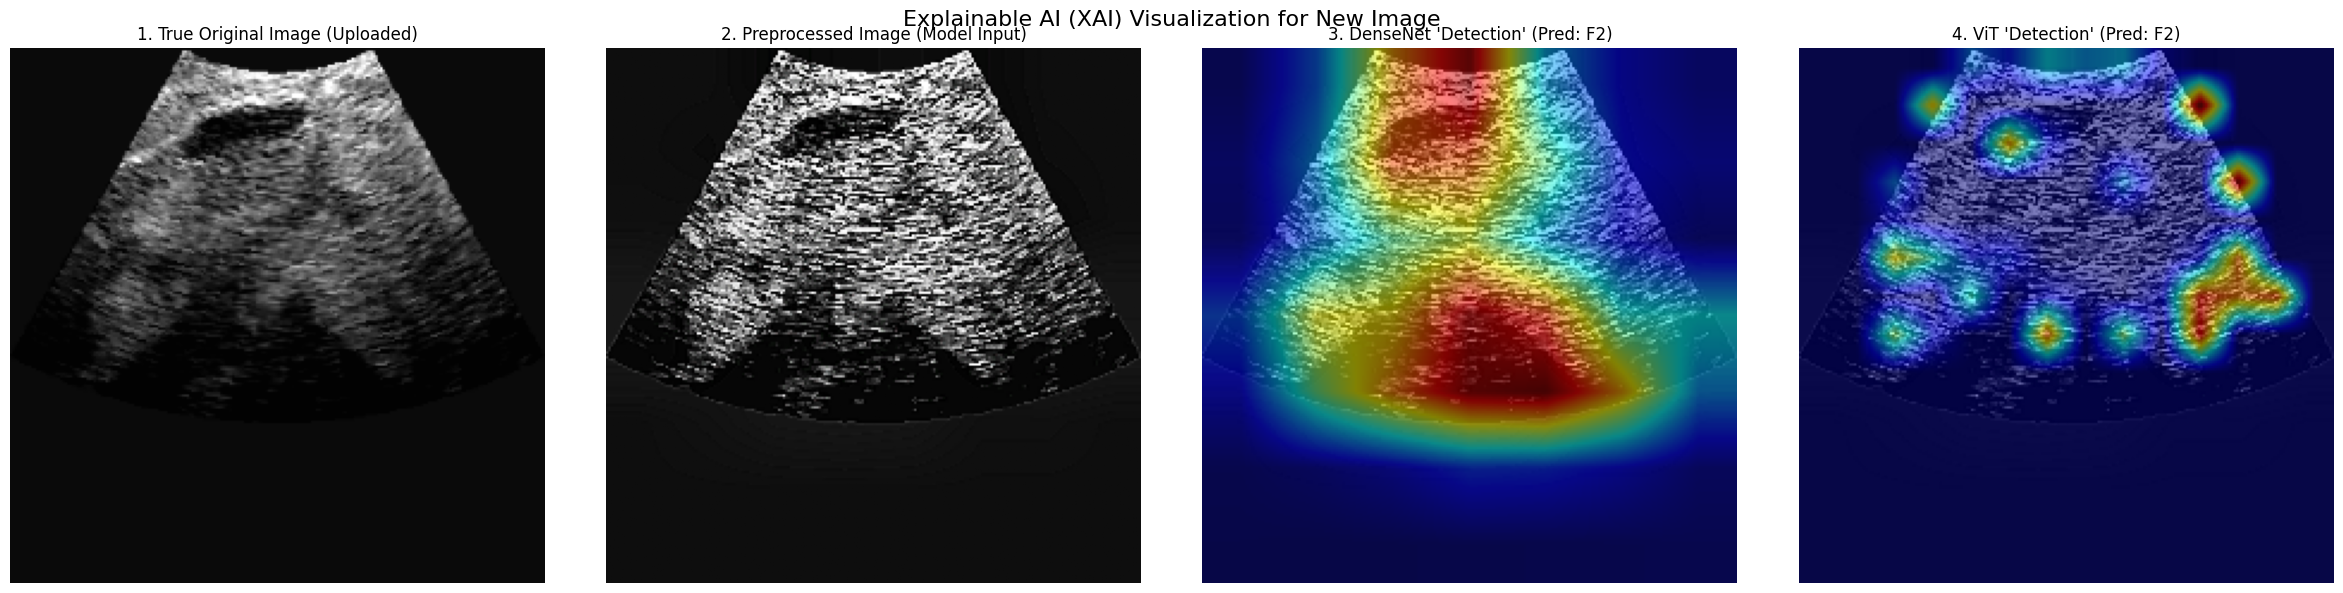

In [30]:
import torch
from pytorch_grad_cam import LayerCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import torch.nn.functional as F

print("🚀 Starting Inference and Visualization for New Image...")

# --- 1. EDIT THIS LINE ---
# Change this to the exact name of the image you uploaded
new_image_path = "/kaggle/input/test-image/t4740.jpg"
# -------------------------

# This map is for printing the final label
class_map_us = { 0: 'F0', 1: 'F1', 2: 'F2', 3: 'F3', 4: 'F4' }

# --- 2. Check if the file exists ---
if not os.path.exists(new_image_path):
    print(f"❌ ERROR: File not found at {new_image_path}")
    print("Please check the 'Upload' button and make sure the filename is correct.")
else:
    print(f"Found image: {new_image_path}")

    # --- 3. Load your ENSEMBLE model (which contains the sub-models) ---
    print("Loading ensemble_model_us.pth...")
    
    # We must re-define the EnsembleHybridModel class so torch can load it
    class EnsembleHybridModel(nn.Module):
        def __init__(self, model_paths, num_classes):
            super().__init__()
            self.num_classes = num_classes
            self.models = nn.ModuleList()
            for path in model_paths:
                model_instance = HybridDenseViT(num_classes=self.num_classes)
                model_instance.load_state_dict(torch.load(path, map_location=CFG.DEVICE))
                model_instance.eval()
                self.models.append(model_instance)
            print(f"Ensemble re-loaded with {len(self.models)} models.")
            
        def forward(self, x):
            probs_list = []
            with torch.no_grad():
                for model in self.models:
                    outputs = model(x); probs = F.softmax(outputs, dim=1)
                    probs_list.append(probs)
            avg_probs = torch.mean(torch.stack(probs_list), dim=0)
            return avg_probs

    # Define the ViT reshape function
    def reshape_transform_vit(tensor, height=14, width=14):
        result = tensor[:, 1:, :].reshape(tensor.size(0), height, width, tensor.size(2))
        result = result.permute(0, 3, 1, 2)
        return result

    # Point to your saved models in the /kaggle/input/saved_model/ folder
    model_paths = [f"/kaggle/input/saved-model/fold{i+1}_best_qwk.pth" for i in range(CFG.N_SPLITS)]
    ensemble_model = EnsembleHybridModel(model_paths, num_classes=CFG.NUM_CLASSES).to(CFG.DEVICE)
    
    # Load the ensemble wrapper from /kaggle/working/ (where Step 11 saved it)
    # or from your input folder if you've restarted
    ensemble_path_1 = "ensemble_model_us.pth"
    ensemble_path_2 = "/kaggle/input/saved_model/ensemble_model_us.pth"
    
    if os.path.exists(ensemble_path_1):
        ensemble_model.load_state_dict(torch.load(ensemble_path_1, map_location=CFG.DEVICE))
    elif os.path.exists(ensemble_path_2):
        ensemble_model.load_state_dict(torch.load(ensemble_path_2, map_location=CFG.DEVICE))
    else:
        print("❌ ERROR: Could not find 'ensemble_model_us.pth'!")
        
    ensemble_model.eval()
    model_to_explain = ensemble_model.models[0] 

    # --- 4. Define target layers ---
    target_layers_cnn = [model_to_explain.cnn.features.norm5]
    target_layers_vit = [model_to_explain.vit.blocks[-1].norm1]

    # --- 5. Create LayerCAM objects ---
    cam_cnn = LayerCAM(model=model_to_explain, target_layers=target_layers_cnn)
    cam_vit = LayerCAM(model=model_to_explain, 
                      target_layers=target_layers_vit,
                      reshape_transform=reshape_transform_vit)
    print("LayerCAM objects created.")

    # --- 6. Load and Preprocess the New Image ---
    print("Processing new image...")
    # Version A: The TRUE Original (Just read and resize)
    true_original_img = cv2.imread(new_image_path)
    true_original_img = cv2.cvtColor(true_original_img, cv2.COLOR_BGR2RGB)
    true_original_img_resized = cv2.resize(true_original_img, (CFG.IMG_SIZE, CFG.IMG_SIZE))

    # Version B: The PREPROCESSED Image (for the model)
    preprocessed_img = preprocess_for_model(new_image_path)
    preprocessed_img_resized = cv2.resize(preprocessed_img, (CFG.IMG_SIZE, CFG.IMG_SIZE))

    # Version C: The TENSOR for the model
    input_tensor = valid_tfms(image=preprocessed_img_resized)["image"].unsqueeze(0).to(CFG.DEVICE)

    # --- 7. Get the Model's Prediction ---
    with torch.no_grad():
        probs = ensemble_model(input_tensor)
        pred_prob = probs.max().item() * 100
        pred_class_idx = torch.argmax(probs, dim=1).item()
        pred_class_label = class_map_us[pred_class_idx]
    
    print(f"\n--- Model Prediction ---")
    print(f"Predicted Label: {pred_class_label} (Class {pred_class_idx})")
    print(f"Confidence: {pred_prob:.2f}%")

    # --- 8. Generate the heatmaps ---
    targets = [ClassifierOutputTarget(pred_class_idx)]
    grayscale_cam_cnn = cam_cnn(input_tensor=input_tensor, targets=targets)[0, :]
    grayscale_cam_vit = cam_vit(input_tensor=input_tensor, targets=targets)[0, :]

    # --- 9. Plot the 4 results ---
    plot_img_preprocessed = preprocessed_img_resized.astype(np.float32) / 255.0
    heatmap_cnn = show_cam_on_image(plot_img_preprocessed, grayscale_cam_cnn, use_rgb=True)
    heatmap_vit = show_cam_on_image(plot_img_preprocessed, grayscale_cam_vit, use_rgb=True) 

    # Create the 4-panel plot
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 6))

    # Plot 1: True Original
    ax1.imshow(true_original_img_resized)
    ax1.set_title(f"1. True Original Image (Uploaded)")
    ax1.axis('off')

    # Plot 2: Preprocessed Image
    ax2.imshow(plot_img_preprocessed)
    ax2.set_title(f"2. Preprocessed Image (Model Input)")
    ax2.axis('off')

    # Plot 3: DenseNet Heatmap
    ax3.imshow(heatmap_cnn)
    ax3.set_title(f"3. DenseNet 'Detection' (Pred: {pred_class_label})")
    ax3.axis('off')

    # Plot 4: ViT Heatmap
    ax4.imshow(heatmap_vit)
    ax4.set_title(f"4. ViT 'Detection' (Pred: {pred_class_label})")
    ax4.axis('off')

    plt.suptitle(f"Explainable AI (XAI) Visualization for New Image", fontsize=16)
    plt.tight_layout()
    plt.show()

In [ ]:
import os
from IPython.display import FileLink

print("🚀 Starting Step 14: Saving all models permanently...")

# Define the name for your zip file
zip_file_name = "ultrasound_hybrid_models.zip"

# Create a list of all the model files you created
files_to_save = [
    "fold1_best_qwk.pth",
    "fold2_best_qwk.pth",
    "fold3_best_qwk.pth",
    "ensemble_model_us.pth" # Your final combined model
]

# Check which files actually exist
existing_files = [f for f in files_to_save if os.path.exists(f)]
print(f"Found {len(existing_files)} model files to save.")

if len(existing_files) > 0:
    # Create the zip command
    zip_command = f"zip -r {zip_file_name} {' '.join(existing_files)}"
    
    print(f"Creating zip file: {zip_file_name}...")
    # Run the zip command in the terminal
    !{zip_command}
    
    print("\n✅ Zip file created successfully!")
    print("---")
    print("👇👇👇 TO DOWNLOAD: 👇👇👇")
    print("1. Look at the 'Output' section in the right-hand panel.")
    print(f"2. Find the file '{zip_file_name}'.")
    print("3. Click the three dots (...) and select 'Download'.")
    
    # You can also try clicking this link:
    display(FileLink(zip_file_name))
else:
    print("⚠️ ERROR: No .pth files were found to save. Did you run Step 9 and 11?")